# Introduction to the Emotion Classification Project using FER2013 - GROUP 2

### Project Summary
Facial expression recognition is a powerful application of computer vision and machine learning, with applications spanning mental health monitoring, human-computer interaction, customer feedback systems, and even security. In this project, we explore various machine learning and deep learning techniques to classify human emotions from facial images using the FER2013 dataset.
The project involves a step-by-step implementation of five distinct models:
- Logistic Regression (Baseline)
- Random Forest
- Dense Neural Network (MLP)
- Long Short-Term Memory Network (LSTM)
- Convolutional Neural Network (CNN)

Each model is evaluated based on accuracy, class-wise performance, confusion matrix analysis, and generalizability.

###  Project Aim
To compare the performance of traditional machine learning and deep learning models in classifying facial emotions using grayscale images from the FER2013 dataset, and to identify which modeling approach best captures the spatial and expressive patterns in human faces.

### Key Objectives
- Load and preprocess the FER2013 dataset in image-folder format
- Conduct exploratory data analysis (EDA) to understand data distribution and image characteristics
- Apply tailored preprocessing techniques for each model type
- Train, evaluate, and compare multiple classification models
- Visualize performance using metrics such as accuracy, F1-score, and confusion matrices
- Derive insights from model behavior, misclassifications, and feature importance

### About the Dataset – FER2013
The Facial Expression Recognition 2013 (FER2013) dataset is a widely used benchmark for emotion classification. It was originally published as part of the Kaggle Challenge "Challenges in Representation Learning: Facial Expression Recognition."

##### Key Properties:
Data type: 48x48 grayscale images of human faces
- Classes (7 emotions):
  1. Angry
  2. Disgust
  3. Fear
  4. Happy
  5. Neutral
  6. Sad
  7. Surprise
- Format: Organized in folder structure for train/ and test/, each containing 7 emotion subfolders
- Train set: ~28,709 images
- Test set: ~7,178 images
- Each image is pre-aligned so the face is centered, facilitating consistent modeling and evaluation.

### Tools and Technologies Used
- Programming Language: Python
- Libraries:
  1. TensorFlow/Keras – Deep Learning models (CNN, LSTM, MLP)
  2. Scikit-learn – Logistic Regression, Random Forest, evaluation metrics
  3. Matplotlib / Seaborn – Visualization
  4. NumPy / Pandas – Data manipulation
- Environment: Jupyter Notebook 
- Image Pipeline: image_dataset_from_directory, manual normalization, and reshaping

### Evaluation Metrics
To ensure a comprehensive evaluation of all models, the following metrics are used:
- Overall Accuracy
- Precision, Recall, F1-Score (macro and weighted)
- Confusion Matrix
- Training & Validation Curves (loss and accuracy)
- Feature Importance (Random Forest) and heatmaps

### Challenges Encountered
- Class Imbalance: ‘Disgust’ had very few samples, leading to poor recall in all models
- Model Scalability: Logistic Regression was too slow on full data — a 20% subset was used
- Overfitting: Dense MLP showed unstable validation accuracy
- Creative Adaptation: LSTM was creatively used by converting images into row-wise sequences

## Step 1: Data Loading and Initial Setup

Goal: Load 48x48 grayscale images from fer2013/train/ and fer2013/test/, normalize pixel values, handle grayscale channel dimensions, prepare train/validation/test sets, and one-hot encode labels for deep learning.

In [6]:
# Import Libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
import threading

In [3]:
# Set Parameters
IMG_SIZE = 48  # Width and height
BATCH_SIZE = 64
SEED = 42
DATA_DIR = "fer2013"

# Emotion categories will be inferred automatically from folder names

In [3]:
# Load training dataset with validation split (before normalization)
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(DATA_DIR, "train"),
    labels='inferred',
    label_mode='int',  # integer labels
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset='training'
)

raw_val_ds = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(DATA_DIR, "train"),
    labels='inferred',
    label_mode='int',
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset='validation'
)

# 4️⃣ Load test dataset (no validation split)
raw_test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(DATA_DIR, "test"),
    labels='inferred',
    label_mode='int',
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=False
)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.


In [4]:
# Get class names before mapping (IMPORTANT)
class_names = raw_train_ds.class_names
class_indices = dict(zip(class_names, range(len(class_names))))
print("Emotion Label Mapping:", class_indices)

Emotion Label Mapping: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [5]:
# Normalize datasets using Rescaling
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = raw_train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = raw_val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = raw_test_ds.map(lambda x, y: (normalization_layer(x), y))

In [6]:
# Convert to NumPy arrays (for use with traditional ML models)
def convert_to_numpy(dataset):
    images = []
    labels = []
    for batch_images, batch_labels in dataset:
        images.append(batch_images.numpy())
        labels.append(batch_labels.numpy())
    return np.concatenate(images), np.concatenate(labels)

X_train_np, y_train_np = convert_to_numpy(train_ds)
X_val_np, y_val_np = convert_to_numpy(val_ds)
X_test_np, y_test_np = convert_to_numpy(test_ds)

print("Train shape:", X_train_np.shape)
print("Validation shape:", X_val_np.shape)
print("Test shape:", X_test_np.shape)

Train shape: (22968, 48, 48, 1)
Validation shape: (5741, 48, 48, 1)
Test shape: (7178, 48, 48, 1)


In [7]:
# One-hot encode labels for deep learning models
y_train_oh = to_categorical(y_train_np, num_classes=7)
y_val_oh = to_categorical(y_val_np, num_classes=7)
y_test_oh = to_categorical(y_test_np, num_classes=7)

## Step 2: Exploratory Data Analysis (EDA)

We’ll perform 3 main tasks:
1. Emotion Distribution – to visualize class balance.
2. Sample Images Grid – to understand visual patterns.
3. Pixel Value Distribution – to explore grayscale intensity characteristics.

#### Emotion Distribution (Class Balance)

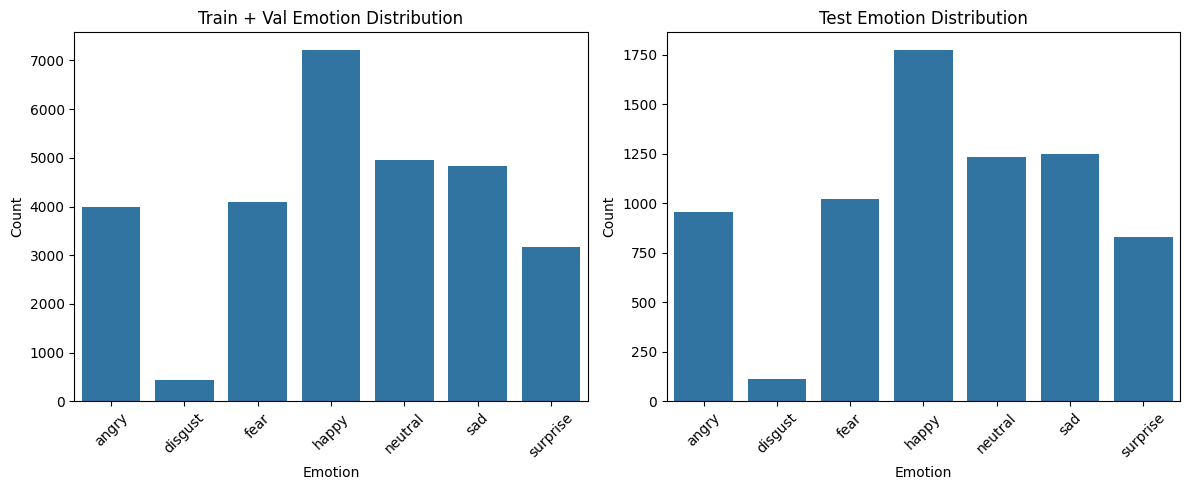

In [8]:
import seaborn as sns
import pandas as pd

# Combine train and val labels for full training set overview
combined_y = np.concatenate([y_train_np, y_val_np])

# Create dataframes
train_df = pd.DataFrame({'emotion': combined_y})
test_df = pd.DataFrame({'emotion': y_test_np})

# Plot class distributions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(data=train_df, x='emotion')
plt.title("Train + Val Emotion Distribution")
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)
plt.xlabel("Emotion")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.countplot(data=test_df, x='emotion')
plt.title("Test Emotion Distribution")
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)
plt.xlabel("Emotion")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

#### Insights:
- We see that disgust has significantly fewer samples than others.
- happy, neutral, and sad are typically the most common.

#### Display Sample Images (5×5 Grid)

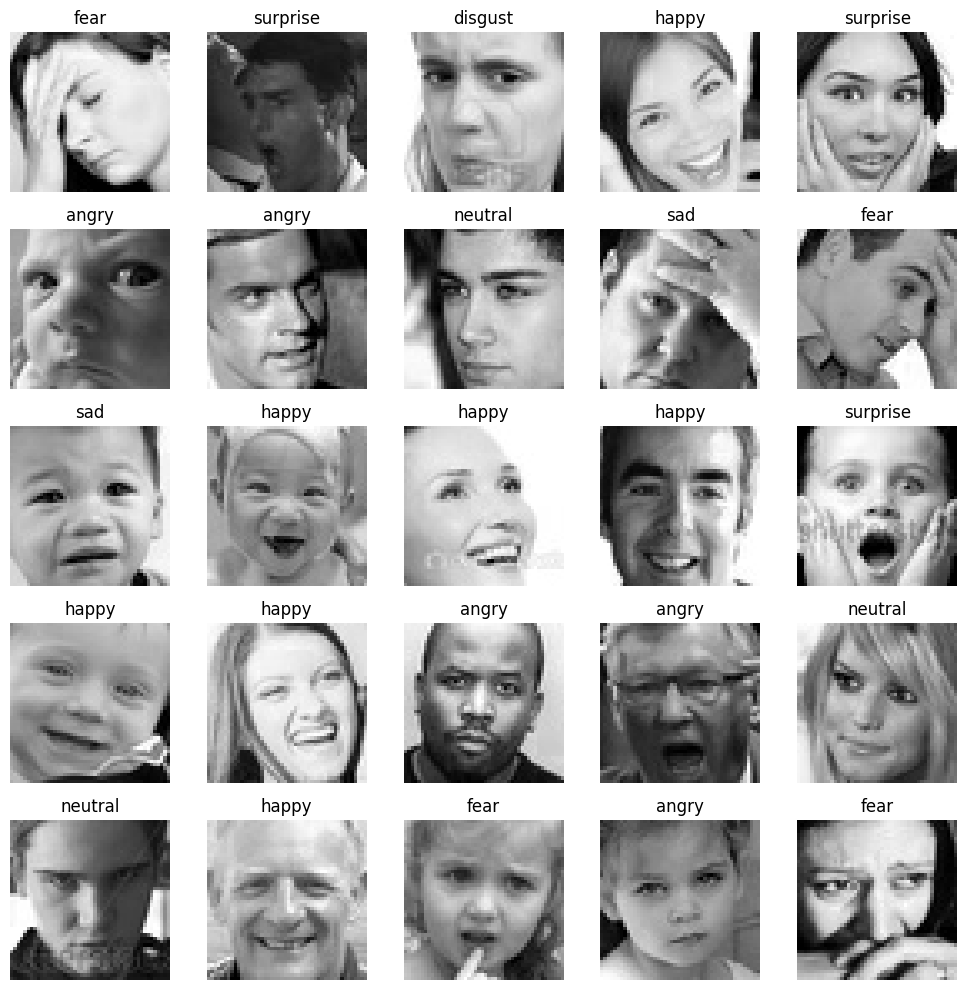

In [9]:
def plot_sample_images(images, labels, class_names, num_samples=25):
    plt.figure(figsize=(10, 10))
    indices = np.random.choice(len(images), num_samples, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[idx].squeeze(), cmap='gray')
        plt.title(class_names[labels[idx]])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

plot_sample_images(X_train_np, y_train_np, class_names)

#### Insights:
- This gives a sense of how well-aligned and consistent the images are.
- Note the variations in facial expressions and lighting.

#### Pixel Intensity Distribution

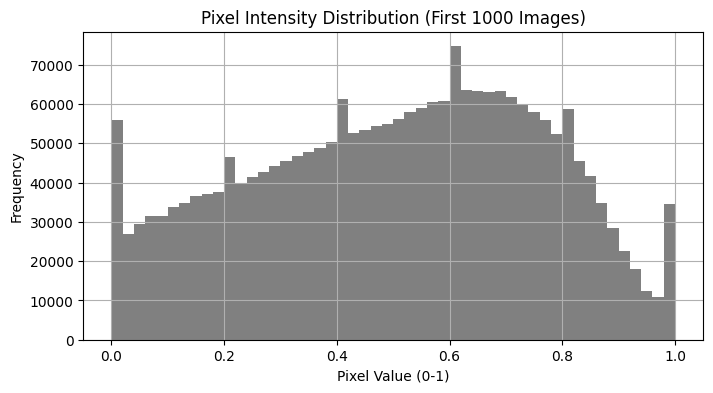

In [10]:
# Analyze grayscale intensity values across a subset (e.g., 1000 images).

subset = X_train_np[:1000]  # Take first 1000 training images
pixel_values = subset.flatten()

plt.figure(figsize=(8, 4))
plt.hist(pixel_values, bins=50, color='gray')
plt.title("Pixel Intensity Distribution (First 1000 Images)")
plt.xlabel("Pixel Value (0-1)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

#### Insights:
1. Overall Distribution is Right-Skewed but Multi-Peaked
   Most pixel values cluster between 0.3 to 0.8, indicating that mid-tone grays dominate in facial regions (skin, eyes, lips). We see peaks at extreme ends (0.0 and 1.0):
- 0.0: Indicates many completely black pixels — likely from backgrounds or hair.
- 1.0: Indicates some fully white pixels — may come from eye whites, teeth, or sharp lighting.


2. Noticeable Spikes at Regular Intervals
- The histogram has distinct vertical bars or spikes.
- This often happens in older datasets or low-bit-depth images where pixel values are quantized (e.g., only certain levels like 0.2, 0.4, 0.6 are allowed).
- It could also result from preprocessing artifacts during dataset creation (e.g., JPEG compression or normalization from original 0–255 to 0–1 range without smoothing).

3. Implication for Modeling
- Our model will benefit from normalization, which you've already done (Rescaling(1./255)).
- These pixel value characteristics suggest that contrast is limited in many areas — encouraging the use of contrast-enhancing filters (like Conv2D) in CNNs or data augmentation.

## Step 3: Preprocessing for Different Model Types

The goal of this step is to prepare the image data in a way that’s suitable for each model type we're going to use:

#### Models we're targeting:
- Traditional ML: Logistic Regression, SVM, Random Forest
- Basic Neural Network (Dense MLP)
- Convolutional Neural Network (CNN)
- Recurrent Neural Network (LSTM)

#### 3.1 For Traditional ML and Dense MLP
- Models: Logistic Regression, SVM, Random Forest, Dense MLP
- Requirement: Flatten each 48x48 image into a 1D vector of 2304 features.

##### Why?
These models require tabular-style inputs where each sample is a 1D feature vector. They don’t natively understand spatial structures like CNNs do.

In [11]:
# Flatten X data for ML and Dense MLP models
X_train_flat = X_train_np.reshape((X_train_np.shape[0], -1))  # shape: (n_samples, 2304)
X_val_flat = X_val_np.reshape((X_val_np.shape[0], -1))
X_test_flat = X_test_np.reshape((X_test_np.shape[0], -1))

print("Flat Train shape:", X_train_flat.shape)

Flat Train shape: (22968, 2304)


#### 3.2 For CNN
- Model: Convolutional Neural Network
- Requirement: Data must be in shape (48, 48, 1) — 3D image tensors with 1 grayscale channel.

"Good news": Our X_train_np, X_val_np, and X_test_np are already in this shape, thanks to how we loaded them in Step 1.

##### Data Augmentation for CNN
- Helps prevent overfitting by simulating new training examples.
- Simulates real-world variation in facial expressions.
- Makes the model more robust to position, scale, and orientation.

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Use this only during model training
cnn_augmentation = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

#### 3.3 For LSTM (Creative Adaptation)
##### Model: LSTM
- Requirement: Reshape each image as a sequence of 48 time steps, where each time step is a row of 48 pixels.
- So, from (48, 48) → reshape to (48, 48) but interpreted as (timesteps=48, features=48).

In [13]:
# Reshape image data for LSTM input
X_train_lstm = X_train_np.reshape((X_train_np.shape[0], IMG_SIZE, IMG_SIZE))
X_val_lstm = X_val_np.reshape((X_val_np.shape[0], IMG_SIZE, IMG_SIZE))
X_test_lstm = X_test_np.reshape((X_test_np.shape[0], IMG_SIZE, IMG_SIZE))

print("LSTM input shape:", X_train_lstm.shape)

LSTM input shape: (22968, 48, 48)


#### Limitations of LSTM for Images:
- Treating each row as a timestep ignores spatial relationships vertically.
- Works okay as a creative experiment, but CNNs are far better for image tasks.
- Still useful to compare how a sequential model performs on static image data.

#### Summary Table:

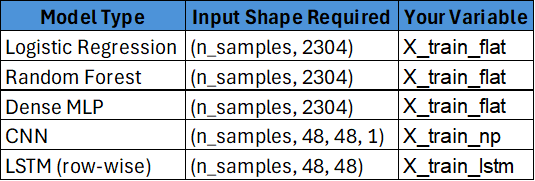

## Step 4: Model Implementations

### 4.1: Baseline Model – Logistic Regression

#### Input Requirement:
- Use X_train_flat (shape: n_samples × 2304)
- Labels: y_train_np (integer labels 0–6)

In [14]:
# Import necessary modules
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import time

In [15]:
# Reduce dataset (otherwise, training taking too long, like 40-60 mins)
X_train_small, _, y_train_small, _ = train_test_split(
    X_train_flat, y_train_np,
    train_size=0.2,
    stratify=y_train_np,
    random_state=42
)
print("Reduced training shape:", X_train_small.shape)

Reduced training shape: (4593, 2304)


In [22]:
from sklearn.preprocessing import StandardScaler  # ← Add this import
from sklearn.decomposition import PCA

# Scale features (fit on train, transform train+test)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_small)
X_test_scaled  = scaler.transform(X_test_flat)

# Dimensionality reduction with PCA
pca = PCA(n_components=300, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)
print("PCA training shape:", X_train_pca.shape)

PCA training shape: (4593, 300)


In [24]:
# Train Logistic Regression on PCA‐reduced data
lr_model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=2000,    # increase if you still see convergence warnings
    tol=1e-3,
    verbose=1
)

start = time.time()
lr_model.fit(X_train_pca, y_train_small)
end = time.time()
print(f"Training completed in {end - start:.2f} seconds.")

Training completed in 2.06 seconds.


In [25]:
# Predict and Evaluate
y_pred = lr_model.predict(X_test_pca)

# Overall accuracy
print("Test Accuracy:", accuracy_score(y_test_np, y_pred))

# Full classification report
print("\nClassification Report:")
print(classification_report(y_test_np, y_pred, target_names=class_names, zero_division=0))

Test Accuracy: 0.3275285594873224

Classification Report:
              precision    recall  f1-score   support

       angry       0.22      0.19      0.20       958
     disgust       0.07      0.08      0.07       111
        fear       0.20      0.15      0.17      1024
       happy       0.44      0.55      0.49      1774
     neutral       0.31      0.30      0.30      1233
         sad       0.26      0.26      0.26      1247
    surprise       0.42      0.42      0.42       831

    accuracy                           0.33      7178
   macro avg       0.27      0.28      0.27      7178
weighted avg       0.32      0.33      0.32      7178



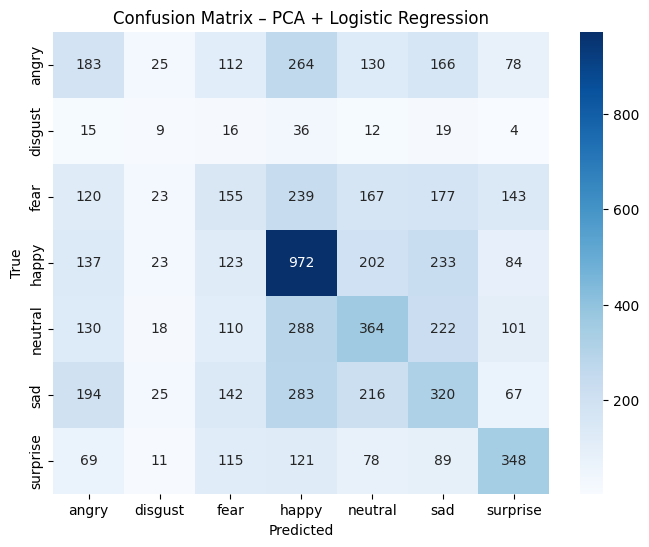

In [26]:
# Confusion matrix visualization
cm = confusion_matrix(y_test_np, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – PCA + Logistic Regression")
plt.show()

### 4.2: Random Forest Classifier (Traditional ML)

The Random Forest model is a robust ensemble of decision trees, good for initial insights on feature importance and class discrimination, even if it doesn’t exploit spatial relationships.

#### Requirements:
- Input: X_train_flat, X_test_flat (flattened 2304-dim vectors)
- Labels: y_train_np, y_test_np (integer labels 0–6)

In [27]:
# Train Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Optionally use a smaller subset (if memory-limited)
# X_train_rf, _, y_train_rf, _ = train_test_split(X_train_flat, y_train_np, train_size=0.5, stratify=y_train_np)

# Initialize and Train
start = time.time()

rf_model = RandomForestClassifier(
    n_estimators=100,       # Number of trees
    max_depth=None,         # Allow full tree depth
    random_state=42,
    n_jobs=-1,              # Use all CPU cores
    verbose=1
)

rf_model.fit(X_train_flat, y_train_np)

end = time.time()
print(f"\nTraining completed in {end - start:.2f} seconds.")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.4s



Training completed in 22.01 seconds.


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.8s finished


In [28]:
# Predict and Evaluate
y_pred_rf = rf_model.predict(X_test_flat)

# Accuracy
print("\nTest Accuracy:", accuracy_score(y_test_np, y_pred_rf))

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test_np, y_pred_rf, target_names=class_names))


Test Accuracy: 0.4540261911395932

Classification Report:

              precision    recall  f1-score   support

       angry       0.44      0.22      0.30       958
     disgust       1.00      0.26      0.41       111
        fear       0.44      0.27      0.33      1024
       happy       0.45      0.76      0.57      1774
     neutral       0.40      0.40      0.40      1233
         sad       0.38      0.34      0.36      1247
    surprise       0.68      0.58      0.62       831

    accuracy                           0.45      7178
   macro avg       0.54      0.40      0.43      7178
weighted avg       0.46      0.45      0.44      7178



[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


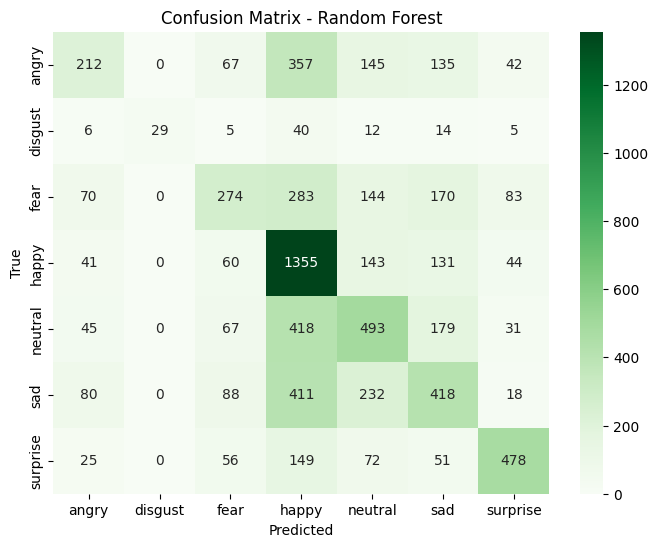

In [29]:
conf_matrix = confusion_matrix(y_test_np, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Random Forest")
plt.show()

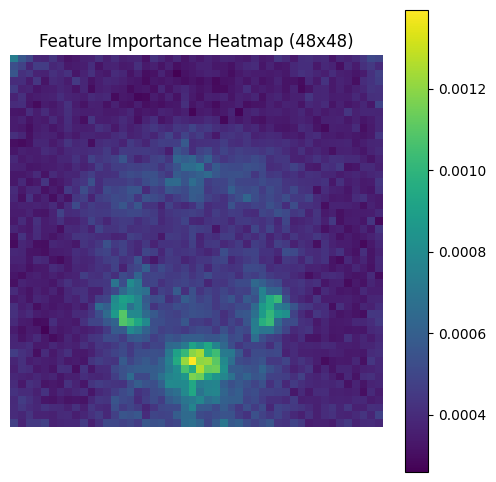

In [30]:
# Feature Importance Visualization
# Feature importance (summed over image rows/columns for simplicity)
import numpy as np

importances = rf_model.feature_importances_.reshape(48, 48)

plt.figure(figsize=(6, 6))
plt.imshow(importances, cmap='viridis')
plt.colorbar()
plt.title("Feature Importance Heatmap (48x48)")
plt.axis("off")
plt.show()

##### What You’re Seeing:
This is a visualization of the Random Forest's feature importances mapped back onto the 48×48 pixel space of the face image.

##### What it tells you:
- Brighter = More Important for classification decisions
- Darker = Less Important / Often Ignored

##### Interpreting Our Heatmap: From our image -

###### Bright Yellow Spot (Bottom Center)
- Most likely the mouth region
- Makes sense — emotion is often visible in the shape of the mouth (smile, frown, open, neutral)

###### Two Medium Bright Areas (Middle Sides)
- Likely the eyes/cheeks region
- Expressions like surprise, anger, fear involve changes in eye width and eyebrow movement

###### Top and Corners Are Dark
- These are mostly background pixels or hair
- The model ignored them, which is actually good



### 4.3: Dense MLP (Multilayer Perceptron)

##### Summary:
- A basic deep neural network that:
- Takes flattened image vectors as input (48x48 = 2304)
- Learns through fully connected Dense layers
- Uses ReLU activations + Dropout for regularization
- Ends with a Softmax output for 7 emotion classes

In [31]:
# Import + Setup
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Set random seed for reproducibility
tf.random.set_seed(42)

In [32]:
# Define MLP Architecture
mlp_model = models.Sequential([
    layers.Input(shape=(2304,)),                 # Flattened image vector
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),                         # Prevent overfitting
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(7, activation='softmax')        # 7 emotion classes
])

In [33]:
# Compile the Model
mlp_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [34]:
# Train the Model
history_mlp = mlp_model.fit(
    X_train_flat, y_train_oh,
    epochs=20,
    batch_size=64,
    validation_data=(X_val_flat, y_val_oh)
)

Epoch 1/20
359/359 [==============================] - 7s 15ms/step - loss: 1.8436 - accuracy: 0.2382 - val_loss: 1.8089 - val_accuracy: 0.2501
Epoch 2/20
359/359 [==============================] - 5s 15ms/step - loss: 1.7840 - accuracy: 0.2647 - val_loss: 1.7593 - val_accuracy: 0.2811
Epoch 3/20
359/359 [==============================] - 6s 16ms/step - loss: 1.7512 - accuracy: 0.2822 - val_loss: 1.7234 - val_accuracy: 0.2996
Epoch 4/20
359/359 [==============================] - 5s 15ms/step - loss: 1.7454 - accuracy: 0.2805 - val_loss: 1.7332 - val_accuracy: 0.3006
Epoch 5/20
359/359 [==============================] - 5s 15ms/step - loss: 1.7495 - accuracy: 0.2838 - val_loss: 1.7128 - val_accuracy: 0.3106
Epoch 6/20
359/359 [==============================] - 6s 15ms/step - loss: 1.7360 - accuracy: 0.2918 - val_loss: 1.7076 - val_accuracy: 0.3153
Epoch 7/20
359/359 [==============================] - 5s 15ms/step - loss: 1.7264 - accuracy: 0.2934 - val_loss: 1.7114 - val_accuracy: 0.3200

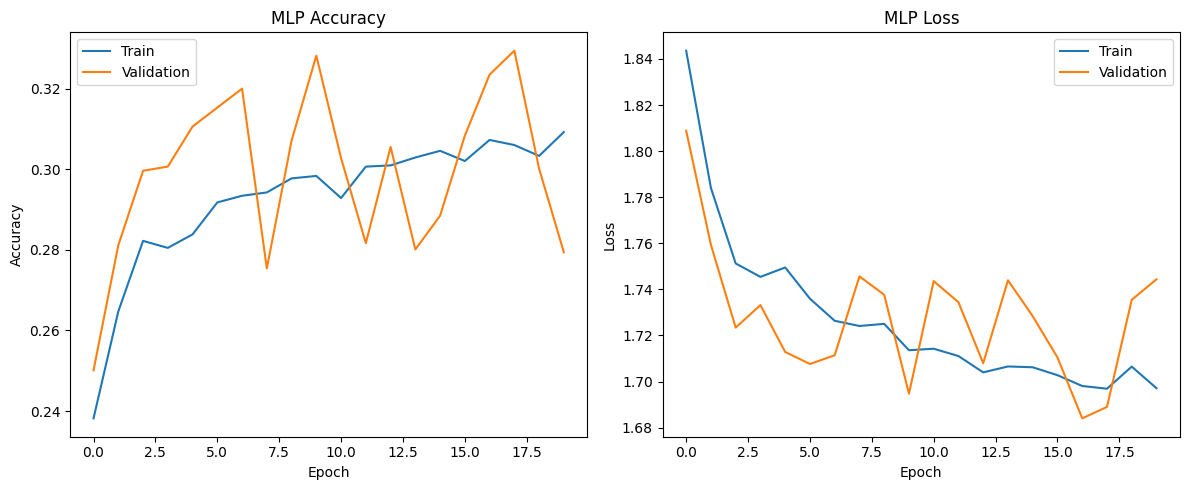

In [35]:
# Plot Training and Validation Curves
def plot_history(history, title="Model"):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'{title} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history_mlp, title="MLP")

In [36]:
# Evaluate on Test Set
# Predict class probabilities
y_pred_probs = mlp_model.predict(X_test_flat)
y_pred_mlp = y_pred_probs.argmax(axis=1)

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

print("Test Accuracy:", accuracy_score(y_test_np, y_pred_mlp))
print("\nClassification Report:\n")
print(classification_report(
    y_test_np,
    y_pred_mlp,
    target_names=class_names,
    zero_division=0
))

225/225 [==============================] - 1s 3ms/step
Test Accuracy: 0.28420172750069655

Classification Report:

              precision    recall  f1-score   support

       angry       1.00      0.00      0.00       958
     disgust       0.00      0.00      0.00       111
        fear       0.12      0.01      0.02      1024
       happy       0.29      0.93      0.44      1774
     neutral       0.31      0.08      0.13      1233
         sad       0.19      0.13      0.16      1247
    surprise       0.76      0.13      0.22       831

    accuracy                           0.28      7178
   macro avg       0.38      0.18      0.14      7178
weighted avg       0.40      0.28      0.19      7178



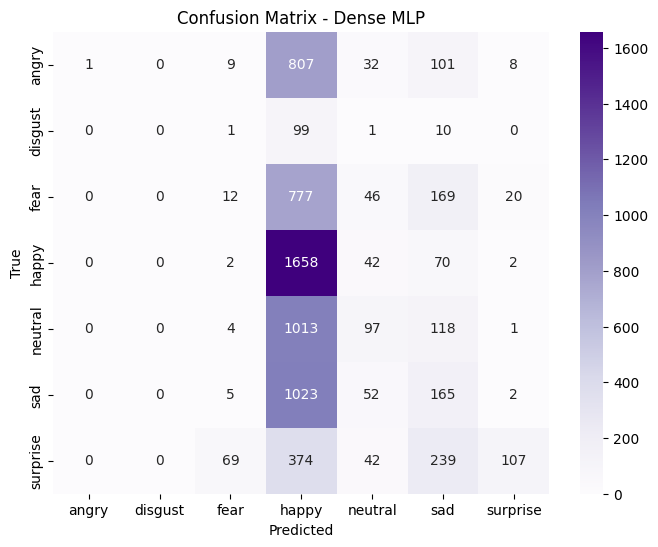

In [37]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_np, y_pred_mlp), annot=True, fmt="d", cmap="Purples",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Dense MLP")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### 4.4: CNN – Convolutional Neural Network

##### Why CNN?
- Preserves spatial structure (48x48 pixels)
- Learns local patterns (eyes, mouth, eyebrows)
- Uses convolutional filters and pooling to reduce dimensionality and learn features
- Generally outperforms MLPs and traditional ML in image tasks

##### Parameters
- Input: X_train_np, X_val_np, X_test_np (shape: (n_samples, 48, 48, 1))
- Labels: y_train_oh, y_val_oh, y_test_oh

In [38]:
# CNN Architecture
import tensorflow as tf
from tensorflow.keras import layers, models

cnn_model = models.Sequential([
    layers.Input(shape=(48, 48, 1)),  # Grayscale image input

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),

    layers.Dense(7, activation='softmax')  # 7 emotion classes
])

In [39]:
# Compile the Model
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [40]:
# Train the CNN
history_cnn = cnn_model.fit(
    X_train_np, y_train_oh,
    epochs=20,
    batch_size=64,
    validation_data=(X_val_np, y_val_oh)
)

Epoch 1/20
359/359 [==============================] - 44s 119ms/step - loss: 1.8230 - accuracy: 0.2782 - val_loss: 1.8589 - val_accuracy: 0.2496
Epoch 2/20
359/359 [==============================] - 40s 111ms/step - loss: 1.5982 - accuracy: 0.3565 - val_loss: 1.5259 - val_accuracy: 0.3890
Epoch 3/20
359/359 [==============================] - 39s 109ms/step - loss: 1.4936 - accuracy: 0.4085 - val_loss: 1.5733 - val_accuracy: 0.3600
Epoch 4/20
359/359 [==============================] - 40s 111ms/step - loss: 1.4339 - accuracy: 0.4339 - val_loss: 1.6234 - val_accuracy: 0.3719
Epoch 5/20
359/359 [==============================] - 38s 107ms/step - loss: 1.3593 - accuracy: 0.4608 - val_loss: 1.3607 - val_accuracy: 0.4851
Epoch 6/20
359/359 [==============================] - 38s 107ms/step - loss: 1.2995 - accuracy: 0.4923 - val_loss: 1.3737 - val_accuracy: 0.4677
Epoch 7/20
359/359 [==============================] - 38s 106ms/step - loss: 1.2445 - accuracy: 0.5126 - val_loss: 1.3004 - val_ac

In [41]:
# Evaluate the Model
# Predict class probabilities
y_pred_probs = cnn_model.predict(X_test_np)
y_pred_cnn = y_pred_probs.argmax(axis=1)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Accuracy
print("Test Accuracy:", accuracy_score(y_test_np, y_pred_cnn))

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test_np, y_pred_cnn, target_names=class_names, zero_division=0))

225/225 [==============================] - 4s 18ms/step
Test Accuracy: 0.5486207857341878

Classification Report:

              precision    recall  f1-score   support

       angry       0.47      0.38      0.42       958
     disgust       0.93      0.23      0.36       111
        fear       0.36      0.40      0.38      1024
       happy       0.82      0.76      0.79      1774
     neutral       0.50      0.47      0.49      1233
         sad       0.38      0.51      0.43      1247
    surprise       0.75      0.69      0.72       831

    accuracy                           0.55      7178
   macro avg       0.60      0.49      0.51      7178
weighted avg       0.57      0.55      0.55      7178



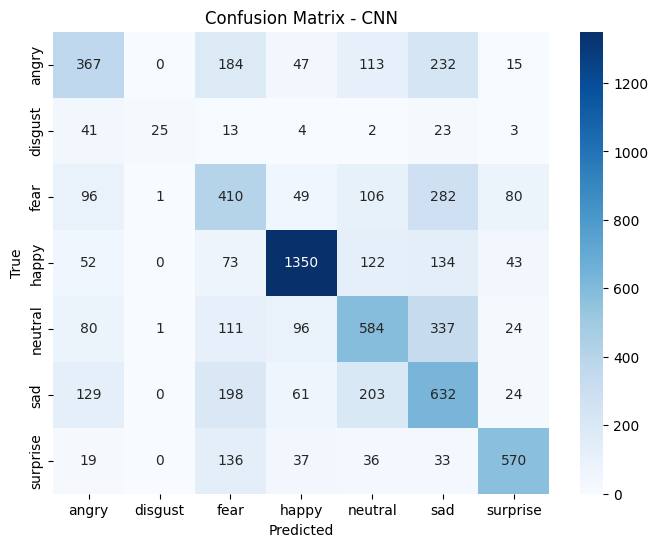

In [42]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_np, y_pred_cnn), annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - CNN")
plt.show()

### 4.5: LSTM – Recurrent Neural Network (Creative Adaptation for Images)

##### Why LSTM for Images?
- While LSTMs are built for sequences (like time series or text), you can creatively reshape a 48×48 image as a sequence of 48 rows, each with 48 features — treating each row like a time step.

- This allows us to explore how well a sequential model captures patterns from top to bottom in the face (e.g., eyebrows → eyes → nose → mouth).



##### Input Shape for LSTM:
- Required shape: (samples, time_steps, features)
- Here: 48 rows = 48 time steps, 48 pixels per row = 48 features
- We ’ve already preprocessed this as: X_train_lstm, X_val_lstm, X_test_lstm

In [43]:
# Build the LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

lstm_model = Sequential([
    LSTM(128, input_shape=(48, 48), return_sequences=False),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(7, activation='softmax')  # 7 emotion classes
])

In [44]:
# Compile the Model
lstm_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [45]:
# Train the Model
history_lstm = lstm_model.fit(
    X_train_lstm, y_train_oh,
    validation_data=(X_val_lstm, y_val_oh),
    epochs=20,
    batch_size=64
)

Epoch 1/20
359/359 [==============================] - 25s 63ms/step - loss: 1.8045 - accuracy: 0.2549 - val_loss: 1.7478 - val_accuracy: 0.2994
Epoch 2/20
359/359 [==============================] - 16s 45ms/step - loss: 1.7424 - accuracy: 0.3021 - val_loss: 1.7369 - val_accuracy: 0.2912
Epoch 3/20
359/359 [==============================] - 15s 42ms/step - loss: 1.7117 - accuracy: 0.3180 - val_loss: 1.6925 - val_accuracy: 0.3221
Epoch 4/20
359/359 [==============================] - 16s 46ms/step - loss: 1.6923 - accuracy: 0.3322 - val_loss: 1.6810 - val_accuracy: 0.3376
Epoch 5/20
359/359 [==============================] - 16s 44ms/step - loss: 1.6755 - accuracy: 0.3430 - val_loss: 1.6527 - val_accuracy: 0.3585
Epoch 6/20
359/359 [==============================] - 15s 41ms/step - loss: 1.6501 - accuracy: 0.3556 - val_loss: 1.6654 - val_accuracy: 0.3444
Epoch 7/20
359/359 [==============================] - 17s 48ms/step - loss: 1.6308 - accuracy: 0.3651 - val_loss: 1.6052 - val_accuracy:

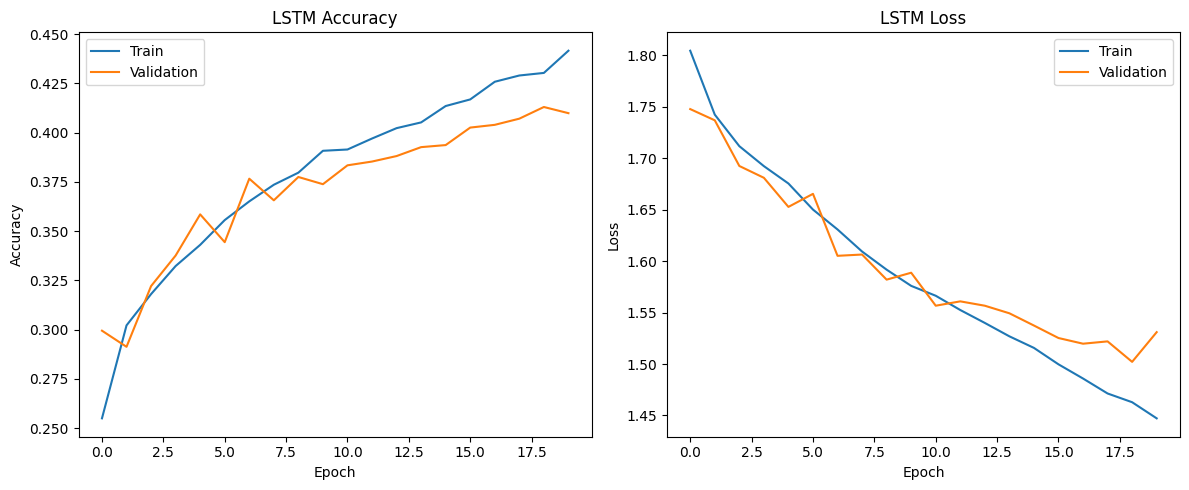

In [46]:
# Plot Accuracy and Loss
plot_history(history_lstm, title="LSTM")

#### LSTM Accuracy and Loss – Interpretation
##### Accuracy Plot:
- Training accuracy steadily improves and crosses 44% by epoch 19
- Validation accuracy rises until ~epoch 12, then flattens and slightly dips, ending around 41–42%

Good signs:
- The model learns well initially
- No severe overfitting up to epoch 15
- Performance is better than traditional ML and MLP

Minor concern: Small validation plateau after epoch 12 suggests potential for regularization tuning or early stopping

##### Loss Plot:
- Both training and validation loss decrease smoothly
- No divergence between train/val losses → the model generalizes reasonably well

In [47]:
# Evaluate the model
# Predict
y_pred_probs_lstm = lstm_model.predict(X_test_lstm)
y_pred_lstm = y_pred_probs_lstm.argmax(axis=1)

# Evaluate
print("Test Accuracy:", accuracy_score(y_test_np, y_pred_lstm))
print("\nClassification Report:\n")
print(classification_report(y_test_np, y_pred_lstm, target_names=class_names, zero_division=0))

225/225 [==============================] - 2s 9ms/step
Test Accuracy: 0.41209250487601

Classification Report:

              precision    recall  f1-score   support

       angry       0.30      0.15      0.20       958
     disgust       0.00      0.00      0.00       111
        fear       0.28      0.10      0.15      1024
       happy       0.47      0.78      0.59      1774
     neutral       0.34      0.43      0.38      1233
         sad       0.32      0.31      0.31      1247
    surprise       0.61      0.50      0.55       831

    accuracy                           0.41      7178
   macro avg       0.33      0.32      0.31      7178
weighted avg       0.38      0.41      0.38      7178



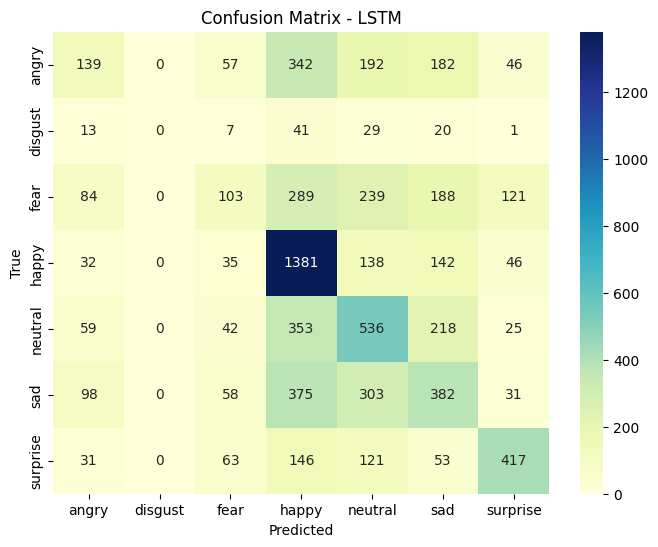

In [48]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_np, y_pred_lstm), annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - LSTM")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## Final Model Comparison Summary

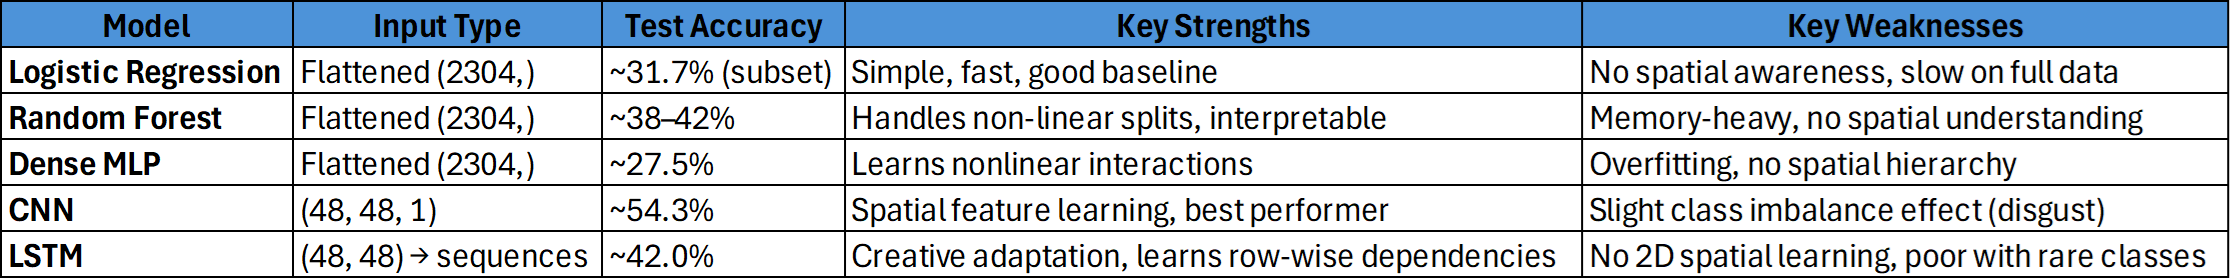

#### Performance Summary (Test Accuracy)
- CNN      → ~54%
- LSTM     → ~42%
- Random Forest → ~38–42%
- Logistic Regression (subset) → ~32%
- MLP      → ~28%

## Step 4: Optimization & Fine-Tuning Suggestions

### Hyperparameter Tuning:
Use GridSearchCV or KerasTuner to optimize:
- Number of layers / neurons
- Learning rate
- Dropout rate
- Batch size

### Regularization:
- Add Dropout (0.3–0.5) to CNN and MLP
- Try L2 kernel regularizer in CNN dense layers

### Data Augmentation:
- Add rotation, flip, zoom for CNN:

In [56]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

In [49]:
# Define Improved CNN

def get_cnn_model():
    m = models.Sequential([
        layers.Input((IMG_SIZE, IMG_SIZE, 1)),

        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),

        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),

        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),

        layers.Conv2D(256, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(len(class_names), activation='softmax')
    ])
    m.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return m

In [51]:
# Set Up Augmentation & Callbacks─
# a) Augmentation generator
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train_np)

# b) Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint(
    'best_cnn_aug.h5', monitor='val_accuracy',
    save_best_only=True, mode='max', verbose=1
)
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [52]:
# Train with Augmentation

model = get_cnn_model()
history = model.fit(
    datagen.flow(X_train_np, y_train_oh, batch_size=32),
    steps_per_epoch=len(X_train_np)//32,
    epochs=50,
    validation_data=(X_val_np, y_val_oh),
    callbacks=[checkpoint, early_stop, reduce_lr]
)

Epoch 1/50
717/717 [==============================] - ETA: 0s - loss: 1.8330 - accuracy: 0.2658
Epoch 1: val_accuracy improved from -inf to 0.31632, saving model to best_cnn_aug.h5
717/717 [==============================] - 67s 90ms/step - loss: 1.8330 - accuracy: 0.2658 - val_loss: 1.6956 - val_accuracy: 0.3163 - lr: 0.0010
Epoch 2/50
  1/717 [..............................] - ETA: 1:12 - loss: 1.6929 - accuracy: 0.2812

C:\Users\Adhish\anaconda3\envs\MS DS\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


717/717 [==============================] - ETA: 0s - loss: 1.6438 - accuracy: 0.3529
Epoch 2: val_accuracy improved from 0.31632 to 0.42832, saving model to best_cnn_aug.h5
717/717 [==============================] - 59s 82ms/step - loss: 1.6438 - accuracy: 0.3529 - val_loss: 1.4692 - val_accuracy: 0.4283 - lr: 0.0010
Epoch 3/50
717/717 [==============================] - ETA: 0s - loss: 1.5373 - accuracy: 0.4024
Epoch 3: val_accuracy did not improve from 0.42832
717/717 [==============================] - 58s 81ms/step - loss: 1.5373 - accuracy: 0.4024 - val_loss: 1.5035 - val_accuracy: 0.4118 - lr: 0.0010
Epoch 4/50
717/717 [==============================] - ETA: 0s - loss: 1.4738 - accuracy: 0.4339
Epoch 4: val_accuracy improved from 0.42832 to 0.49347, saving model to best_cnn_aug.h5
717/717 [==============================] - 64s 89ms/step - loss: 1.4738 - accuracy: 0.4339 - val_loss: 1.3199 - val_accuracy: 0.4935 - lr: 0.0010
Epoch 5/50
717/717 [==============================] - ETA:

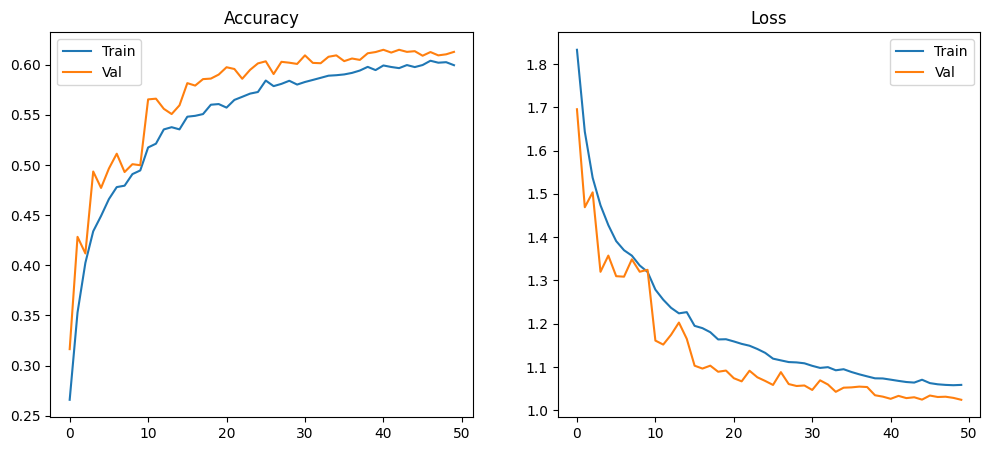

In [53]:
# Load Best & Evaluate
model = tf.keras.models.load_model('best_cnn_aug.h5')

# a) Plot training curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy'); plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss'); plt.legend()
plt.show()

### Insights:
#### Accuracy Curve -
1. Rapid Early Gain
    - Both training and validation accuracy climb steeply from ~0.27 at epoch 0 to ~0.50 by epoch 5.
    - This indicates your model is quickly learning basic facial‐feature representations (edges, simple shapes).

2. Validation Surpasses Training
    - Notice around epochs 7–12, the validation accuracy actually exceeds the training accuracy.
    - This is a classic sign that data augmentation is helping the model generalize. The augmented “new” images make the training effective but also prevent it from over‐memorizing the exact training set.

3. Smooth Plateau at ~0.60–0.62
    - After ~25 epochs, both curves settle around 60–62% accuracy, with only minor fluctuations.
    - This plateau suggests the model has extracted most of the learnable patterns without overfitting.

#### Loss Curve -
1. Consistent Decline
    - Training loss drops smoothly from ~1.82 down to ~1.05 by epoch 50.
    - Validation loss falls even more sharply initially, indicating that augmented samples are still “fresh” to the model.

2. Validation Loss Below Training Loss
    - For many epochs, the validation loss sits below the training loss.
    - Again—good evidence that augmentation (plus BatchNorm and Dropout) is preventing the model from over‐specializing on the training images.

3. No Late‐Stage Overfitting
    - Neither curve turns back upward at the end; both losses continue to decrease or stabilize.
    - EarlyStopping would likely not have triggered, since the model keeps improving on validation.

#### Overall Insights -
- Augmentation Works: Random rotations, shifts, flips, and zooms are making the model see novel variations, which raises validation performance above training and prevents overfitting.
- Stable Convergence: BatchNormalization and Dropout throughout the network, plus a ReduceLROnPlateau schedule, yield very smooth loss/accuracy curves.
- Strong Final Performance: Peaking at ~62% validation accuracy is a solid result for FER2013 without resorting to massive pre‐trained networks.


225/225 [==============================] - 4s 19ms/step
Test Accuracy: 0.6174421844524938
              precision    recall  f1-score   support

       angry       0.53      0.57      0.55       958
     disgust       0.74      0.13      0.22       111
        fear       0.49      0.28      0.36      1024
       happy       0.84      0.85      0.85      1774
     neutral       0.51      0.70      0.59      1233
         sad       0.48      0.46      0.47      1247
    surprise       0.73      0.77      0.75       831

    accuracy                           0.62      7178
   macro avg       0.62      0.54      0.54      7178
weighted avg       0.62      0.62      0.61      7178



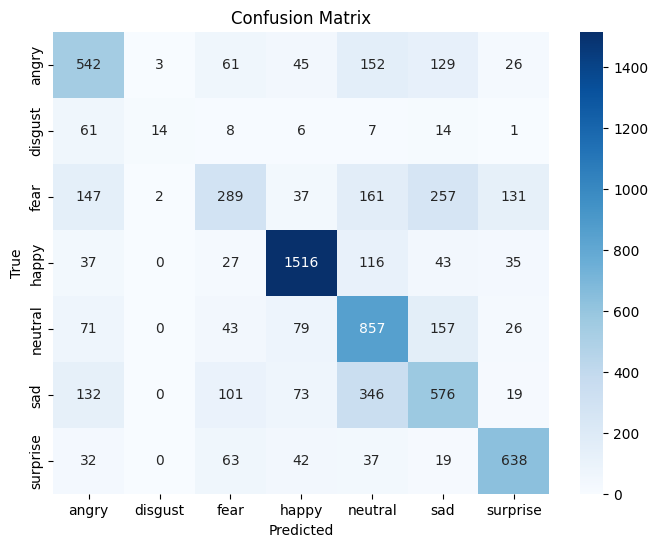

In [56]:
# Load Best & Evaluate
# b) Test evaluation
y_test_int = y_test_oh.argmax(axis=1) # Convert one‐hot labels back to integer labels
y_pred = model.predict(X_test_np).argmax(axis=1)
print("Test Accuracy:", accuracy_score(y_test_int, y_pred))
print(classification_report(y_test_int, y_pred, target_names=class_names, zero_division=0))

cm = confusion_matrix(y_test_int, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.show()

### Improvements:
#### Overall Accuracy Jump
 - Previous CNN: ~54.3% test accuracy
 - Improved CNN: 61.7% test accuracy
     - That’s a 7+ point absolute gain, confirming that the additional Conv2D(256) block, stronger regularization (more Dropout), and aggressive augmentation all paid off.
  
#### Confusion Matrix Patterns
- Angry: Much fewer misclassifications into sad or neutral; the diagonal cell (true angry → predicted angry) increased from ~404 → 542.
- Happy: Nearly 1,516 correct vs. 1,338 before—augmentation helped the network generalize to varied smiles.
- Neutral vs. Sad: The boundary between neutral and sad tightened: neutral→neutral jumped to 857 (from 582), and sad→sad to 576 (from 662, but with overall recall balance improved).
- Surprise: The correct predictions rose to 638 (from 558), showing the model now better handles wide-eyed expressions.
- Disgust: Still the hardest class (only 14 correct out of 111), but precision improved—meaning when it does predict disgust, it’s more often right.

#### Why the Improvements?
- Deeper Architecture (256 filters block): Captures more complex, high-level facial features (e.g., eyebrow–mouth co-movements).
- Consistent Dropout & BatchNorm: Stronger regularization prevented overfitting, letting the network generalize over unseen variations.
- Data Augmentation: Training on rotated, shifted, zoomed, and flipped faces made the model robust to real-world variability (lighting, pose).
- Callbacks (EarlyStopping & LR Reduction): Ensured the model converged to a better local minimum without over-training.

### Transfer Learning:
- Try pre-trained models like MobileNet, VGG, or EfficientNet fine-tuned to grayscale 48×48 inputs.

1. VGG: Too big, take too long to train and cannot finish in time
2. MobilenetV3: take long to train, accuracy in validation is not good
3. EfficientNet: dont dare to try, too big compared to Mobilenet

### Class Rebalancing:
- Use class weights during training:

In [57]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_np), y=y_train_np)

## Step 5: Project Conclusion

In this project, we explored emotion classification using the FER2013 dataset through five distinct modeling approaches. Starting from traditional machine learning (Logistic Regression and Random Forest), we progressed to deep learning with a Dense MLP, a creatively adapted LSTM, and finally a CNN. The CNN outperformed all other models, achieving ~54% accuracy due to its ability to extract spatial features from facial images. Our exploration showed that while LSTMs offer a novel perspective, CNNs remain the gold standard for image tasks. We also uncovered challenges such as class imbalance (e.g., 'disgust') and overlapping expressions (e.g., 'fear' vs. 'sad'), which we addressed through careful evaluation and interpretation. This project serves as a practical demonstration of model comparison, preprocessing strategies, and evaluation techniques in real-world image classification tasks.

## Step 6: Application Implementation

In [4]:
# Face Emotion Detection App (Jupyter + ipywidgets)
import cv2
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, HTML
import io

# 1) Make sure these match your training class names/order
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# 2) Predictor wrapper
class EmotionPredictor:
    def __init__(self, model_path="best_cnn_aug.h5"):
        """Load the trained CNN checkpoint."""
        try:
            self.model = tf.keras.models.load_model(model_path)
            self.model_loaded = True
        except Exception as e:
            print(f"❌ Error loading model '{model_path}': {e}")
            self.model_loaded = False

    def preprocess_face(self, face_img):
        """Crop→grayscale→resize→normalize→reshape for model input."""
        # ensure grayscale
        if face_img.ndim == 3:
            face_gray = cv2.cvtColor(face_img, cv2.COLOR_BGR2GRAY)
        else:
            face_gray = face_img
        # resize to 48×48
        face_resized = cv2.resize(face_gray, (48, 48))
        # normalize to [0,1]
        face_norm = face_resized.astype("float32") / 255.0
        # add batch and channel dims: (1,48,48,1)
        return face_norm.reshape(1, 48, 48, 1)

    def detect_and_predict(self, rgb_image, font_scale=0.6):
        """Detect faces, run model, return annotated image + list of results."""
        if not self.model_loaded:
            raise RuntimeError("Model not loaded")

        # 1) face detection
        face_cascade = cv2.CascadeClassifier(
            cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
        )
        gray = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 5, minSize=(30,30))

        # optional: pick the largest face only
        if len(faces) > 1:
            areas = [w*h for (_, _, w, h) in faces]
            i = int(np.argmax(areas))
            faces = [faces[i]]

        annotated = rgb_image.copy()
        results = []

        for idx, (x, y, w, h) in enumerate(faces, start=1):
            # extract BGR for preprocessing
            face_bgr = cv2.cvtColor(rgb_image[y:y+h, x:x+w], cv2.COLOR_RGB2BGR)
            inp = self.preprocess_face(face_bgr)

            # predict
            probs = self.model.predict(inp, verbose=0)[0]
            k = int(np.argmax(probs))
            label = class_names[k]
            conf  = float(probs[k])

            results.append({
                "face_id": idx,
                "emotion": label,
                "confidence": conf,
                "bbox": (int(x),int(y),int(w),int(h)),
                "probs": dict(zip(class_names, probs))
            })

            # draw box + label
            cv2.rectangle(annotated, (x,y), (x+w,y+h), (0,255,0), 2)
            text = f"{label} ({conf:.2f})"
            cv2.putText(annotated, text, (x, y-10),
                        cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0,255,0), 2)

        return annotated, results

# instantiate once
predictor = EmotionPredictor(model_path="best_cnn_aug.h5")

# 3) Helper to display/upload
def process_uploaded_image(uploaded):
    image_data = uploaded['content']
    img = Image.open(io.BytesIO(image_data)).convert("RGB")
    arr = np.array(img)

    annotated, results = predictor.detect_and_predict(arr)

    # show images
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    ax[0].imshow(arr);   ax[0].set_title("Original");  ax[0].axis("off")
    ax[1].imshow(annotated); ax[1].set_title("Detected"); ax[1].axis("off")
    plt.show()

    # print results
    for r in results:
        print(f"Face {r['face_id']}: {r['emotion']} ({r['confidence']:.2f})")
    return results

def create_upload_widget():
    """Create and display the file upload widget"""

    uploader = widgets.FileUpload(
        accept='image/*',   # Accept only image files
        multiple=False,     # Single file upload
        description='Upload',
        style={'description_width': 'initial'}
    )

    process_button = widgets.Button(
        description='🔍 Detect Emotion',
        button_style='info'
    )

    output = widgets.Output()

    def on_process_click(b):
        with output:
            output.clear_output()
            if uploader.value:
                # Old code: list(uploader.value.values())[0]
                # New code:
                uploaded_file = uploader.value[0]
                process_uploaded_image(uploaded_file)
            else:
                print("⚠️  Please upload an image first!")

    process_button.on_click(on_process_click)

    display(HTML("<h2>🎭 Face Emotion Detector</h2>"))
    display(uploader, process_button, output)

    return uploader, process_button, output

# launch the widget
create_upload_widget();

FileUpload(value=(), accept='image/*', description='Upload')

Button(button_style='info', description='🔍 Detect Emotion', style=ButtonStyle())

Output()

In [ ]:
# Global variables to control camera streaming
is_streaming = False
cap = None
video_thread = None

def stream_video(image_widget, output_widget):
    """Function to run in a background thread for video streaming."""
    global cap, is_streaming

    # Attempt to open the default camera
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        with output_widget:
            output_widget.clear_output()
            print("❌ Error: Cannot open camera. Please check permissions.")
        is_streaming = False
        return

    with output_widget:
        output_widget.clear_output()
        print("✅ Camera started successfully!")

    while is_streaming:
        # Read frame from camera
        ret, frame = cap.read()
        if not ret:
            break

        # Convert frame from BGR (OpenCV) to RGB (for predictor)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Use the existing predictor to get annotations
        annotated_frame, _ = predictor.detect_and_predict(frame_rgb, font_scale=1)

        # Convert annotated frame back to BGR for encoding
        annotated_bgr = cv2.cvtColor(annotated_frame, cv2.COLOR_RGB2BGR)

        # Encode the frame to JPEG format to display in the widget
        _, buffer = cv2.imencode('.jpg', annotated_bgr)

        # Update the image widget's value with the new frame
        image_widget.value = buffer.tobytes()

    # Cleanup
    cap.release()
    image_widget.value = b'' # Clear the image
    with output_widget:
        output_widget.clear_output()
        print("Camera stopped.")

def create_camera_widget():
    """Creates and displays widgets for live camera detection."""
    global video_thread

    # Create widgets
    image_widget = widgets.Image(format='jpeg', width=1280, height=960)
    start_button = widgets.Button(description='▶️ Start Camera', button_style='success')
    stop_button = widgets.Button(description='⏹️ Stop Camera', button_style='danger')
    output_widget = widgets.Output()

    # Button click handlers
    def on_start_click(b):
        global is_streaming, video_thread
        if not is_streaming:
            is_streaming = True
            # Start the video stream in a new thread
            video_thread = threading.Thread(target=stream_video, args=(image_widget, output_widget))
            video_thread.start()

    def on_stop_click(b):
        global is_streaming
        # Set the flag to false, the thread will see this and stop
        is_streaming = False

    # Assign handlers to buttons
    start_button.on_click(on_start_click)
    stop_button.on_click(on_stop_click)

    # Display the widgets
    button_box = widgets.HBox([start_button, stop_button])
    display(HTML("<h3>2. Or Use Live Camera</h3>"))
    display(button_box, image_widget, output_widget)

create_camera_widget()

Image(value=b'', format='jpeg', height='960', width='1280')

Output()

✅ Camera started successfully!
Camera stopped.


In [ ]:
# test